##### import libs

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from copy import deepcopy
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

from utils import load_data, evaluate, plot_feature_importances

##### load data

In [2]:
user_item_data, user_meta_data, item_meta_data, test_pairs_data = load_data()

In [3]:
user_embeddings = np.load("dumps/user_embeddings.npy")
item_embeddings = np.load("dumps/item_embeddings.npy")
user_biases = np.load("dumps/user_biases.npy")
item_biases = np.load("dumps/item_biases.npy")
lightfm_scores = np.load("dumps/lightfm_scores.npy")
test_lightfm_scores = np.load("dumps/test_lightfm_scores.npy")

In [4]:
user_item_data

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit
0,3810,138979,6,0,0,0,0,0
1,101874,331160,6,0,0,0,0,0
2,150332,73709,11,0,0,0,0,0
3,4982,189745,5,0,0,0,0,0
4,149601,289643,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
145667277,10718,93558,7,0,0,0,0,0
145667278,119164,60206,60,0,0,0,0,0
145667279,171518,99323,70,0,0,0,0,0
145667280,109533,74203,1,0,0,0,0,0


In [5]:
test_pairs_data_w_columns = test_pairs_data.copy()

for col in set(user_item_data.columns) - set(test_pairs_data.columns):
    test_pairs_data_w_columns[col] = 0

In [14]:
test_user_item_data = user_item_data[user_item_data.user_id.isin(test_pairs_data.user_id.values)]

In [22]:
test_likes = test_user_item_data.groupby("user_id").like.agg("max")
test_dislikes = test_user_item_data.groupby("user_id").dislike.agg("max")

In [20]:
test_pairs_data.user_id.nunique()

82756

In [27]:
(test_dislikes | test_likes).value_counts()

1    80225
0     2531
Name: count, dtype: int64

In [29]:
not_test_users = set(user_item_data.user_id.unique()) - set(test_pairs_data.user_id.values)

In [33]:
len(not_test_users)

100648

In [23]:
test_dislikes.value_counts()

dislike
0    72126
1    10630
Name: count, dtype: int64

In [19]:
test_likes.value_counts()

like
1    79893
0     2863
Name: count, dtype: int64

##### create features

user_meta_data["user_lightfm_embeddings"] = user_embeddings.tolist()
item_meta_data["item_lightfm_embeddings"] = item_embeddings.tolist()
user_meta_data["user_lightfm_biases"] = user_biases.tolist()
item_meta_data["item_lightfm_biases"] = item_biases.tolist()

In [7]:
user_item_data["lightfm_scores"] = lightfm_scores.tolist()

In [8]:
test_pairs_data_w_columns["lightfm_scores"] = test_lightfm_scores.tolist()

In [9]:
user_item_data = pd.concat((user_item_data, test_pairs_data_w_columns), axis=0, ignore_index=True)

In [9]:
item_meta_data = item_meta_data.rename({"embeddings": "video_embeddings"}, axis=1)

In [12]:
user_item_data = user_item_data.merge(
    item_meta_data.drop(columns="video_embeddings"), on="item_id", how="left"
)

: 

In [10]:
user_item_data = user_item_data.merge(user_meta_data, on="user_id", how="left")

In [ ]:
user_item_data["timespent_rel"] = (
    user_item_data["timespent"] / user_item_data["duration"]
)

In [11]:
user_item_data.lightfm_scores = user_item_data.lightfm_scores.astype(np.float16)
# user_item_data.timespent_rel = user_item_data.timespent_rel.astype(np.float16)

In [12]:
user_item_data.like = user_item_data.like.astype(np.int8)
user_item_data.dislike = user_item_data.dislike.astype(np.int8)
user_item_data.share = user_item_data.share.astype(np.int8)
user_item_data.bookmarks = user_item_data.bookmarks.astype(np.int8)
user_item_data.explicit = user_item_data.explicit.astype(np.int8)

In [13]:
user_item_data.dtypes

user_id             int64
item_id             int64
timespent           int64
like                 int8
dislike              int8
share                int8
bookmarks            int8
explicit             int8
lightfm_scores    float16
gender              uint8
age                 uint8
dtype: object

#### скользящие фичи

In [14]:
test_counts_by_user = test_pairs_data.groupby(by="user_id").agg(len)
test_counts_by_user.value_counts()

item_id
20         82756
Name: count, dtype: int64

In [23]:
count_by_user = user_item_data.groupby(by="user_id").like.agg(len)

In [50]:
(count_by_user>24).sum()

182670

In [28]:
user_item_data.user_id.nunique()*20

3668080

In [40]:
test_user_item_data = user_item_data[user_item_data.user_id.isin(test_pairs_data.user_id.unique())]

In [42]:
count_by_test_user = test_user_item_data.groupby(by="user_id").like.agg(len)

In [48]:
count_by_test_user[count_by_test_user==4]

user_id
122460    4
Name: like, dtype: int64

In [49]:
user_item_data[user_item_data.user_id==122460]

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,lightfm_scores,source_id,duration,gender,age,timespent_rel
96730821,122460,331635,17,0,0,0,0,0,-1.609375,18699,17,2,38,1.000000
100812389,122460,30314,38,0,0,0,0,0,-1.879883,18603,42,2,38,0.904785
100812544,122460,176903,6,0,0,0,0,0,-1.440430,13407,5,2,38,1.200195
114553510,122460,126534,2,0,0,0,0,0,-1.869141,18466,20,2,38,0.099976


In [26]:
count_by_user.min()

2

In [ ]:
like_count_by_user = user_item_data.groupby(by="user_id").like.agg("sum")
like_ratio_by_user = like_count_by_user / user_item_data.groupby(by="user_id").like.agg(len)

In [13]:
user_item_data

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,lightfm_scores
0,3810,138979,6,0,0,0,0,0,-4.929688
1,101874,331160,6,0,0,0,0,0,-2.806641
2,150332,73709,11,0,0,0,0,0,-4.921875
3,4982,189745,5,0,0,0,0,0,-6.171875
4,149601,289643,1,0,0,1,0,0,-4.906250
...,...,...,...,...,...,...,...,...,...
147322397,183403,235097,0,0,0,0,0,0,-4.164062
147322398,183403,267411,0,0,0,0,0,0,-5.886719
147322399,183403,273646,0,0,0,0,0,0,-7.441406
147322400,183403,288305,0,0,0,0,0,0,-7.707031


In [14]:
def compute_rolling_features(df,
                             group_col,
                             target_col,
                             lags,
                             windows,
                             agg_funcs):
    """
    Computes rolling lag, window and expanding window features for a target column within groups of a specified column.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        group_col (str): Column name to group by.
        target_col (str): Column name for which lagged features are computed.
        lags (list): List of lag steps to compute.
        windows (list): List of window sizes to compute.
        agg_funcs (list): List of functions to be used for aggregation.

    Returns:
        pd.DataFrame: DataFrame with additional rolling features.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    result_df = df.copy()
    
    #########
    result_df.loc[-int(len(result_df)*0.15):].like = 0
    #########

    # Group by the specified column and apply shifting for each lag
    grouped = result_df.groupby(group_col, as_index=False)
    for lag in tqdm(lags):
        result_df[f"{target_col}_lag_{lag}"] = grouped[target_col].shift(lag).fillna(0).astype(np.int8)

    for window in tqdm(windows):
        for agg_func in agg_funcs:
            result_df[f"{target_col}_window_{window}_agg_{agg_func}"] = grouped[target_col].rolling(window=window, min_periods=0).agg(agg_func).like.astype(np.int16)
    
    return result_df

In [15]:
# Compute rolling features for "like" with lags 1 and 2
lags = list(range(1,5))
windows = [2, 5, 10, 20, 50, 100, 200, 500]
agg_funcs = ["sum",]

data_with_rolling_features = compute_rolling_features(user_item_data,
                                                      group_col="user_id",
                                                      target_col="like",
                                                      lags=lags,
                                                      windows=windows,
                                                      agg_funcs=agg_funcs)

100%|██████████| 8/8 [12:36<00:00, 94.55s/it] 


In [16]:
columns = ['user_id', 'item_id', 'lightfm_scores', 'source_id', 'duration',
       'gender', 'age', 'like_1', 'like_2', 'like_3',
       'like_4', 'like_5', 'like_6', 'like_7', 'like_8', 'like_9', 'like_10',
       'like_20', 'like_30', 'like_40', 'like_50', 'like_60', 'like_70',
       'like_80', 'like_90']
target = "explicit"

In [17]:
columns = list(set(data_with_rolling_features.columns) - set(['like', 'dislike', 'explicit', 'bookmarks', 'timespent', 'timespent_rel', 'share']))
target = "explicit"

In [18]:
train_df, val_df = train_test_split(data_with_rolling_features[columns+[target]],
                                    test_size=0.15,
                                    random_state=42,
                                    shuffle=False)

In [18]:
train_df = data_with_rolling_features[:-len(test_pairs_data)]

In [19]:
val_df = data_with_rolling_features[-len(test_pairs_data):]

##### catboost

In [20]:
model = CatBoostClassifier(verbose=True,
                           iterations=100)

In [21]:
model.fit(train_df[-10000000:][columns],
          train_df[-10000000:][target])

Learning rate set to 0.5
0:	learn: 0.3698879	total: 958ms	remaining: 1m 34s
1:	learn: 0.1972251	total: 1.73s	remaining: 1m 24s
2:	learn: 0.1128861	total: 2.53s	remaining: 1m 21s
3:	learn: 0.0669209	total: 3.27s	remaining: 1m 18s
4:	learn: 0.0406797	total: 4.06s	remaining: 1m 17s
5:	learn: 0.0253590	total: 4.85s	remaining: 1m 15s
6:	learn: 0.0163223	total: 5.68s	remaining: 1m 15s
7:	learn: 0.0109787	total: 6.52s	remaining: 1m 14s
8:	learn: 0.0078293	total: 7.38s	remaining: 1m 14s
9:	learn: 0.0059903	total: 8.15s	remaining: 1m 13s
10:	learn: 0.0049143	total: 8.91s	remaining: 1m 12s
11:	learn: 0.0043129	total: 9.68s	remaining: 1m 10s
12:	learn: 0.0039805	total: 10.5s	remaining: 1m 10s
13:	learn: 0.0038094	total: 11.3s	remaining: 1m 9s
14:	learn: 0.0037025	total: 12s	remaining: 1m 8s
15:	learn: 0.0036502	total: 12.9s	remaining: 1m 7s
16:	learn: 0.0036160	total: 13.7s	remaining: 1m 6s
17:	learn: 0.0036015	total: 14.5s	remaining: 1m 6s
18:	learn: 0.0035933	total: 15.3s	remaining: 1m 5s
19:	l

In [22]:
catboost_predict = model.predict(val_df[columns])

In [23]:
catboost_proba = model.predict_proba(val_df[columns])

In [1]:
catboost_proba[]

NameError: name 'catboost_proba' is not defined

In [24]:
test_pairs_data["predict"] = catboost_proba[:,2]
test_pairs_data.to_csv("./submission.csv",index=False)

In [35]:
test_pairs_data

,user_id,item_id
0,1,7363
1,1,73770
2,1,75700
3,1,81204
4,1,110249
...,...,...
1655115,183403,235097
1655116,183403,267411
1655117,183403,273646
1655118,183403,288305


In [34]:
catboost_predict.flatten().shape

(1655120,)

In [25]:
model.classes_

array([-1,  0,  1])

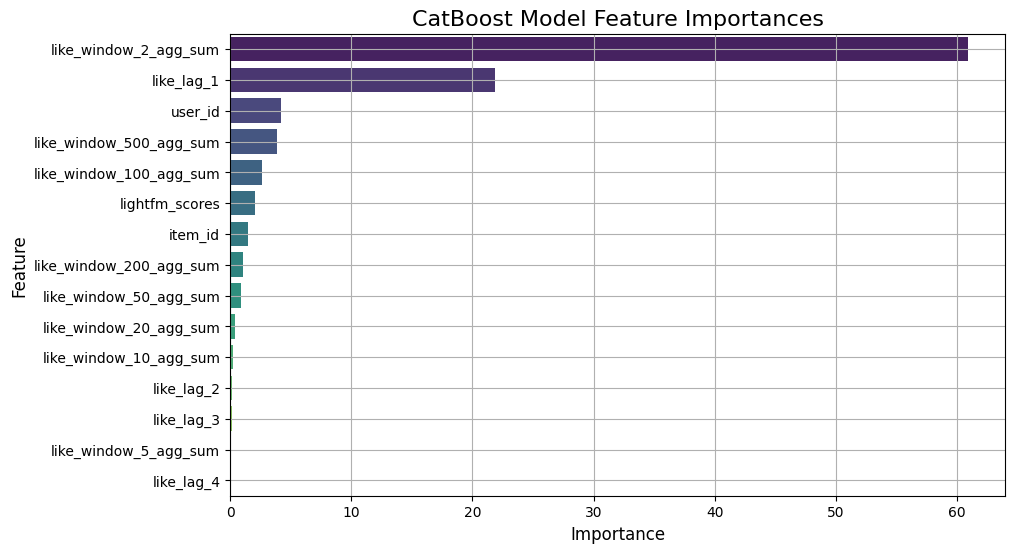

In [36]:
plot_feature_importances(model, graphic=True)

In [27]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_predict.flatten())

100%|██████████| 181721/181721 [00:21<00:00, 8514.17it/s]


0.9842272982076817

In [36]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,0])

100%|██████████| 181721/181721 [00:52<00:00, 3488.98it/s]


0.015931021937499436

In [37]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,1])

100%|██████████| 181721/181721 [00:51<00:00, 3496.19it/s]


0.016609268323484652

In [38]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         -catboost_proba[:,1])

100%|██████████| 181721/181721 [00:52<00:00, 3456.46it/s]


0.9833907316765154

In [66]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,2])

100%|██████████| 181721/181721 [00:51<00:00, 3519.39it/s]


0.6186407527015462

In [40]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         val_df.lightfm_scores.values)

100%|██████████| 181721/181721 [00:51<00:00, 3549.42it/s]


0.6206784531327687

i want to fucking make it work without leak